<a href="https://colab.research.google.com/github/LinaTobon/Proyecticos-/blob/main/An%C3%A1lisis_Titanic_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TITANIC SURVIVAL PREDICTION 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2, f_classif
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.utils.multiclass import unique_labels

#### 1. IMPORTING DATA

In [10]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### 2. IMPUTING NULL VALUES

In [12]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [13]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#### class distribution

In [14]:
train.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


##### filling age nulls with the median per Pclass

In [15]:
train['Age'] = train.groupby(['Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))


In [16]:
test['Age'] = test.groupby(['Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

In [17]:
train.loc[train['PassengerId']==6]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,24.0,0,0,330877,8.4583,NaN,Q


#### test dataset filling fare missing data with 0

In [18]:
test['Fare'] = test['Fare'].fillna(0)

#### FEATURE SCALING

In [19]:
from sklearn.preprocessing import minmax_scale

#### 4. FEATURE ENGINEERING

##### Feature extraction

##### Family and hasfamily features

In [20]:
train['Family'] = train['Parch'] + train['SibSp']

In [21]:
test['Family'] = test['Parch'] + test['SibSp']

In [22]:
hasfamily = (train.Family>0)*1
train['hasfamily'] = hasfamily

In [23]:
hasfamily = (test.Family>0)*1
test['hasfamily'] = hasfamily

In [24]:
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,hasfamily
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,1


##### Agesplit

In [25]:
agesplit = [0,10,18,25,40,90]
agestatus = ['Adolescent','Teenager','Young Adult','Adult','Elder']

train['agegroup'] = pd.cut(train.Age,agesplit,labels=agestatus)

In [26]:
test['agegroup'] = pd.cut(test.Age,agesplit,labels=agestatus)

##### embarked

In [27]:
train['embarkedport'] = train.Embarked.map({'C':'Cherbourg','Q':'Queenstown','S':'Southampton'})

In [28]:
test['embarkedport'] = test.Embarked.map({'C':'Cherbourg','Q':'Queenstown','S':'Southampton'})

##### SES

In [29]:
train['ses'] = train.Pclass.map({1:'upper',2:'middle',3:'lower'})

In [30]:
test['ses'] = test.Pclass.map({1:'upper',2:'middle',3:'lower'})

#### FARE PER PERSON

In [31]:
train['Fare_Per_Person'] = train['Fare']/(train['Family']+1)
train['Fare_Per_Person'] =  train['Fare_Per_Person'].astype(int)

In [32]:
test['Fare_Per_Person'] = test['Fare']/(train['Family']+1)
test['Fare_Per_Person'] =  test['Fare_Per_Person'].astype(int)

### TITLE

In [33]:
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr','Major', 'Rev', 'Sir', 
                                         'Jonkheer', 'Dona'], 'Rare')

train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

In [34]:
test['Title'] = test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr','Major', 'Rev', 'Sir', 
                                         'Jonkheer', 'Dona'], 'Rare')

test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

In [35]:
train['Title'] = train['Title'].fillna(0)
test['Title'] = test['Title'].fillna(0)

### AGE PER CLASS

In [36]:
train['Age_Class'] = train['Age'] * train['Pclass']

In [37]:
train['Age_Class'] = train['Age'] * train['Pclass']

https://www.kaggle.com/c/titanic/discussion/4693

In [38]:
cat_var = ['ses','embarkedport','hasfamily','Sex','agegroup','Title']
nominal_var = ['embarkedport','Sex','agegroup','Title']
bin_var = ['hasfamily']
ord_var = ['ses']
num_var = ['Fare','Family','Age','Fare_Per_Person','Age_Class']

#### Categorical features visualization

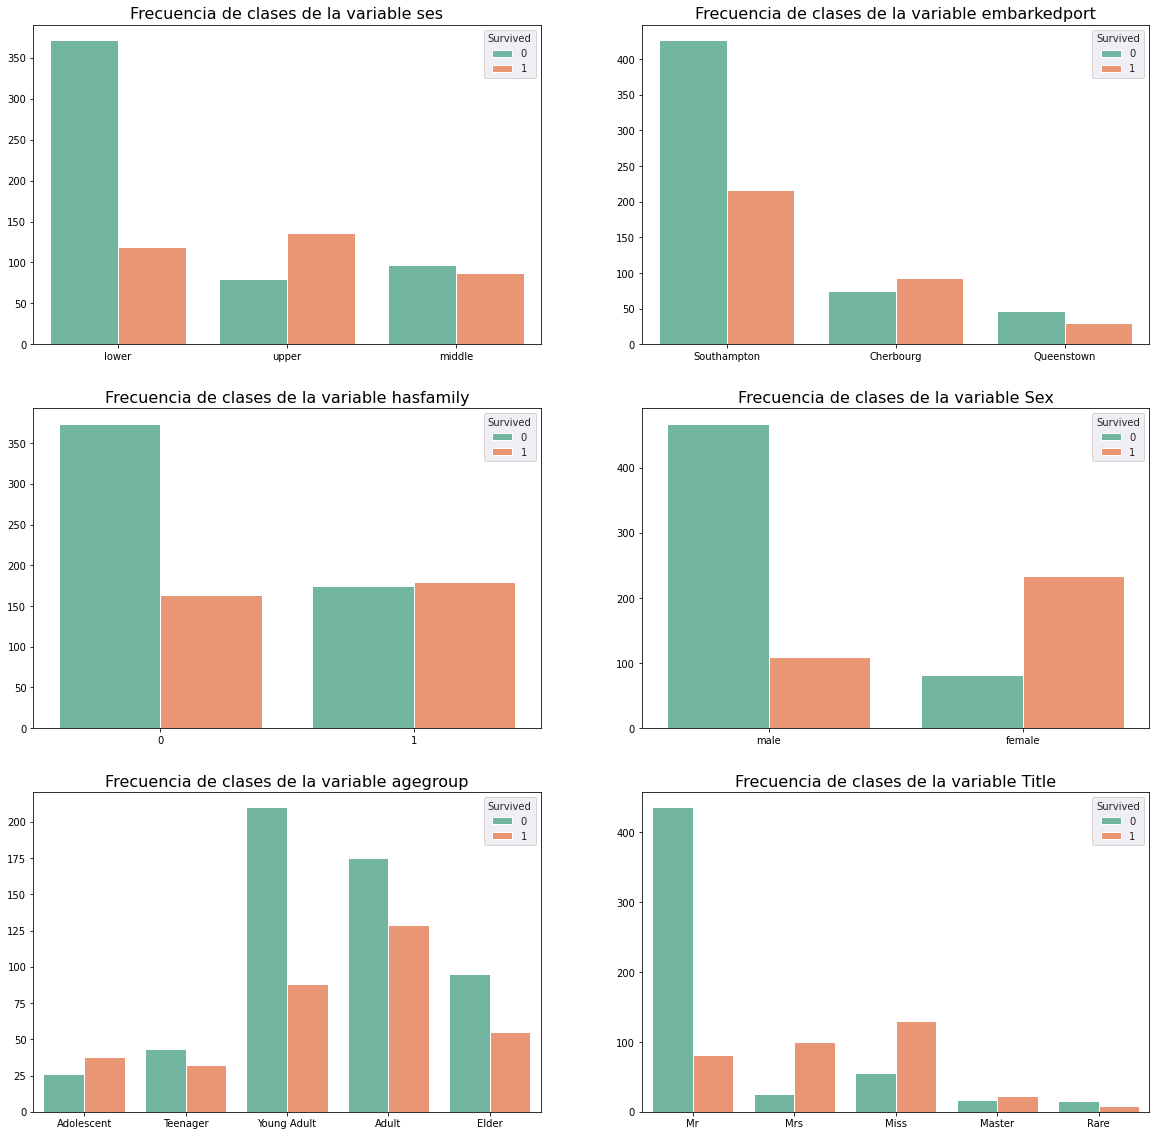

In [39]:
(figure, axis) = plt.subplots(nrows =3 , ncols=2, figsize=(20,20))

ax = axis.flat

sns.set_style("darkgrid")
for i in range(len(cat_var)):
    sns.countplot(x = cat_var[i], hue='Survived',data=train, ax= ax[i],palette="Set2")
    ax[i].set_title('Frecuencia de clases de la variable '+ cat_var[i], fontsize = 16)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('');

#### Numerical features

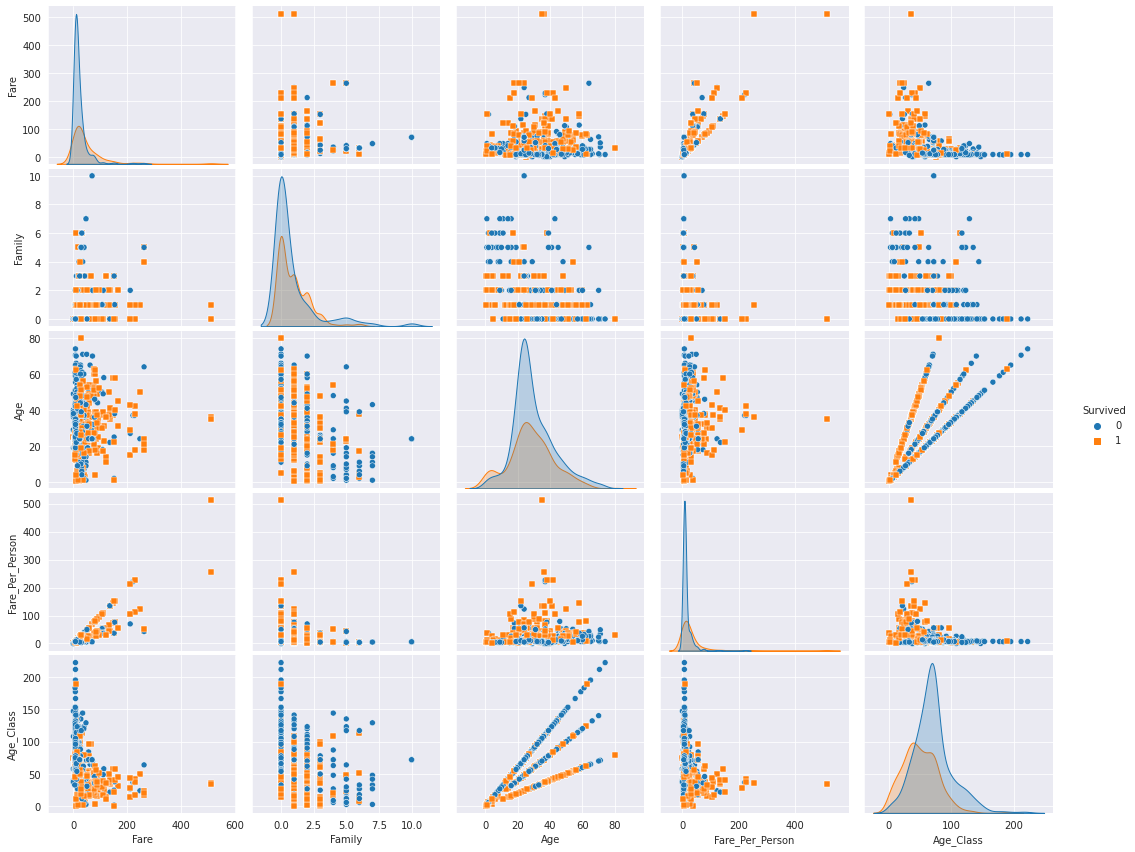

In [40]:
pair_plot=sns.pairplot(data=train, hue='Survived',vars=num_var,  markers=["o", "s"])
pair_plot.fig.set_size_inches(16,12)

https://towardsdatascience.com/would-you-survive-the-titanic-a-classic-challenge-on-kaggle-3efaa22bfb5e

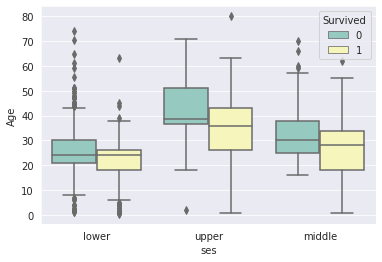

In [41]:
ax = sns.boxplot(x="ses", y="Age", hue="Survived",data=train, palette="Set3")

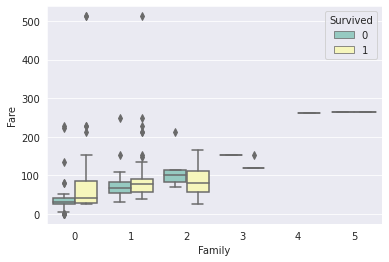

In [42]:
ax = sns.boxplot(x="Family", y="Fare", hue="Survived",data=train[train['ses']=='upper'], palette="Set3")

#### Drop unuseful features

In [43]:
train.drop(axis=1, columns=['Cabin','Ticket','Name','PassengerId','Embarked','Pclass','Parch','SibSp'],inplace=True)

In [44]:
test.drop(axis=1, columns=['Cabin','Ticket','Name','PassengerId','Embarked','Pclass','Parch','SibSp'],inplace=True)

In [45]:
train.head()

,Survived,Sex,Age,Fare,Family,hasfamily,agegroup,embarkedport,ses,Fare_Per_Person,Title,Age_Class
0,0,male,22.0,7.2500,1,1,Young Adult,Southampton,lower,3,Mr,66.0
1,1,female,38.0,71.2833,1,1,Adult,Cherbourg,upper,35,Mrs,38.0
2,1,female,26.0,7.9250,0,0,Adult,Southampton,lower,7,Miss,78.0
3,1,female,35.0,53.1000,1,1,Adult,Southampton,upper,26,Mrs,35.0
4,0,male,35.0,8.0500,0,0,Adult,Southampton,lower,8,Mr,105.0


#### ENCODING CATEGORICAL VARIABLES

https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a

In [46]:
encod_data_train=pd.get_dummies(data = train,columns= nominal_var + bin_var, drop_first=True)

In [47]:
encod_data_test=pd.get_dummies(data = test,columns= nominal_var + bin_var, drop_first=True)

In [48]:
# Codificación para variables ordinales
ord_enc= OrdinalEncoder(dtype=int)

encod_data_train.loc[:,['ses']] = ord_enc.fit_transform(encod_data_train.loc[:,['ses']])


In [49]:
encod_data_test.loc[:,['ses']] = ord_enc.fit_transform(encod_data_test.loc[:,['ses']])

In [50]:
encod_data_train.head()

,Survived,Age,Fare,Family,ses,Fare_Per_Person,Age_Class,embarkedport_Queenstown,embarkedport_Southampton,Sex_male,agegroup_Teenager,agegroup_Young Adult,agegroup_Adult,agegroup_Elder,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,hasfamily_1
0,0,22.0,7.2500,1,0,3,66.0,0,1,1,0,1,0,0,0,1,0,0,1
1,1,38.0,71.2833,1,2,35,38.0,0,0,0,0,0,1,0,0,0,1,0,1
2,1,26.0,7.9250,0,0,7,78.0,0,1,0,0,0,1,0,1,0,0,0,0
3,1,35.0,53.1000,1,2,26,35.0,0,1,0,0,0,1,0,0,0,1,0,1
4,0,35.0,8.0500,0,0,8,105.0,0,1,1,0,0,1,0,0,1,0,0,0


In [51]:
encod_data_test.columns

Index(['Age', 'Fare', 'Family', 'ses', 'Fare_Per_Person',
       'embarkedport_Queenstown', 'embarkedport_Southampton', 'Sex_male',
       'agegroup_Teenager', 'agegroup_Young Adult', 'agegroup_Adult',
       'agegroup_Elder', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
       'hasfamily_1'],
      dtype='object')

In [52]:
le_enc_y = LabelEncoder()
encod_data_train['Survived'] = le_enc_y.fit_transform(encod_data_train['Survived'])

### FEATURE SELECTION

https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

#### Filter feature selection methods

#### ANOVA correlation coefficent for Numerical input variables

In [53]:
x_num = encod_data_train[num_var]

In [54]:
num_var

['Fare', 'Family', 'Age', 'Fare_Per_Person', 'Age_Class']

In [55]:
y = encod_data_train['Survived']

In [56]:
fs = SelectKBest(score_func=f_classif, k=2)
X_selected = fs.fit_transform(x_num, y)
fs.transform(x_num)

list(zip(x_num,fs.scores_,fs.pvalues_))

[('Fare', 63.03076422804438, 6.120189341922221e-15),
 ('Family', 0.24619311233986654, 0.6198911221344969),
 ('Age', 1.989577805288128, 0.1587348317092724),
 ('Fare_Per_Person', 45.753218024110645, 2.429578534238841e-11),
 ('Age_Class', 100.47619881003389, 1.7741125313130428e-22)]

In [57]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

# predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=2)
selector.fit(x_num, y)

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?


In [58]:
scores

array([14.21323514,  0.20768458,  0.79932776, 10.61446906, 21.75101884])

https://blog.minitab.com/blog/adventures-in-statistics-2/understanding-analysis-of-variance-anova-and-the-f-test

#### Chi squared

In [59]:
x_cat = encod_data_train[['ses','embarkedport_Queenstown','embarkedport_Southampton', 'Sex_male', 'hasfamily_1','agegroup_Teenager',
       'agegroup_Young Adult', 'agegroup_Adult', 'agegroup_Elder','Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']]

In [60]:
chi2_best_var = SelectKBest(chi2,k=5).fit(x_cat,y)

In [61]:
pd.DataFrame({'var':x_cat.columns,'scores':chi2_best_var.scores_, 'p_value':chi2_best_var.pvalues_}).sort_values('scores', ascending=False)

,var,scores,p_value
10,Title_Mr,112.805785,2.379805e-26
0,ses,103.096103,3.192784e-24
3,Sex_male,92.702447,6.077838e-22
11,Title_Mrs,89.474177,3.106671e-21
9,Title_Miss,79.531749,4.745381e-19
4,hasfamily_1,22.209338,2.444818e-06
6,agegroup_Young Adult,9.876809,1.673750e-03
2,embarkedport_Southampton,5.984840,1.442935e-02
7,agegroup_Adult,2.108727,1.464611e-01
5,agegroup_Teenager,0.581674,4.456570e-01


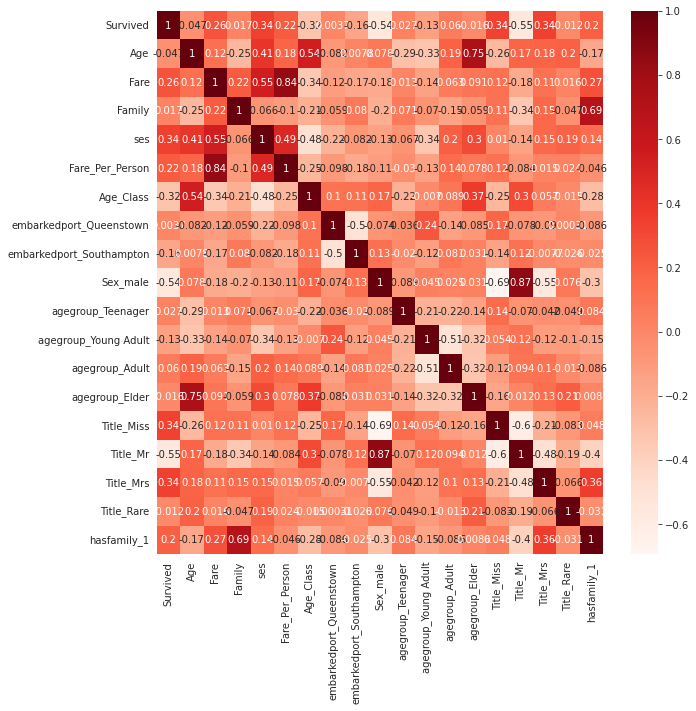

In [62]:
#Using Pearson Correlation
plt.figure(figsize=(10,10))
cor = encod_data_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#### Wrapping methods

In [63]:
from yellowbrick.features import RFECV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

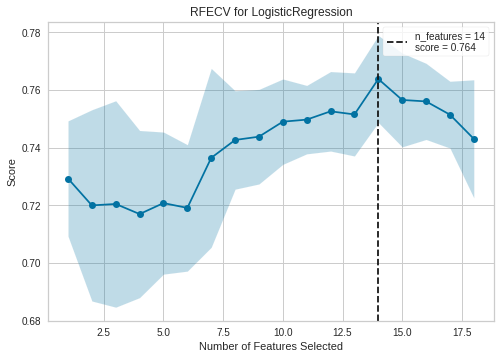

<Axes: title={'center': 'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [64]:
viz1 = RFECV(LogisticRegression(), cv=3, scoring='f1')
viz1.fit(encod_data_train.drop(columns = ['Survived']),encod_data_train['Survived'])
viz1.poof()

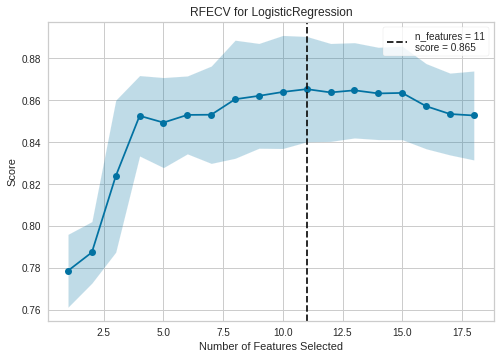

<Axes: title={'center': 'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [65]:
viz2 = RFECV(LogisticRegression(), cv=3, scoring='roc_auc')
viz2.fit(encod_data_train.drop(columns = ['Survived']),encod_data_train['Survived'])
viz2.poof()

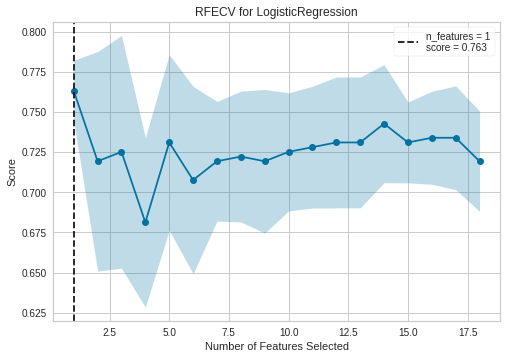

<Axes: title={'center': 'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [66]:
viz3 = RFECV(LogisticRegression(), cv=3, scoring='recall')
viz3.fit(encod_data_train.drop(columns = ['Survived']),encod_data_train['Survived'])
viz3.poof()

In [67]:
features_sel_1 = list(encod_data_train.drop(columns = ['Survived']).columns[viz1.support_])
features_rank_1=list(zip(encod_data_train.drop(columns = ['Survived']),viz1.ranking_,viz1.support_))
features_rank_1

[('Age', 2, False),
 ('Fare', 3, False),
 ('Family', 1, True),
 ('ses', 1, True),
 ('Fare_Per_Person', 5, False),
 ('Age_Class', 4, False),
 ('embarkedport_Queenstown', 1, True),
 ('embarkedport_Southampton', 1, True),
 ('Sex_male', 1, True),
 ('agegroup_Teenager', 1, True),
 ('agegroup_Young Adult', 1, True),
 ('agegroup_Adult', 1, True),
 ('agegroup_Elder', 1, True),
 ('Title_Miss', 1, True),
 ('Title_Mr', 1, True),
 ('Title_Mrs', 1, True),
 ('Title_Rare', 1, True),
 ('hasfamily_1', 1, True)]

In [68]:
features_sel_2 = list(encod_data_train.drop(columns = ['Survived']).columns[viz2.support_])
features_rank_2=list(zip(encod_data_train.drop(columns = ['Survived']),viz2.ranking_,viz2.support_))
features_rank_2

[('Age', 5, False),
 ('Fare', 6, False),
 ('Family', 1, True),
 ('ses', 1, True),
 ('Fare_Per_Person', 8, False),
 ('Age_Class', 7, False),
 ('embarkedport_Queenstown', 4, False),
 ('embarkedport_Southampton', 2, False),
 ('Sex_male', 1, True),
 ('agegroup_Teenager', 1, True),
 ('agegroup_Young Adult', 1, True),
 ('agegroup_Adult', 1, True),
 ('agegroup_Elder', 1, True),
 ('Title_Miss', 1, True),
 ('Title_Mr', 1, True),
 ('Title_Mrs', 3, False),
 ('Title_Rare', 1, True),
 ('hasfamily_1', 1, True)]

In [69]:
features_sel_3 = list(encod_data_train.drop(columns = ['Survived']).columns[viz3.support_])
features_rank_3 = list(zip(encod_data_train.drop(columns = ['Survived']),viz3.ranking_,viz3.support_))
features_rank_3

[('Age', 15, False),
 ('Fare', 16, False),
 ('Family', 7, False),
 ('ses', 3, False),
 ('Fare_Per_Person', 18, False),
 ('Age_Class', 17, False),
 ('embarkedport_Queenstown', 14, False),
 ('embarkedport_Southampton', 12, False),
 ('Sex_male', 4, False),
 ('agegroup_Teenager', 9, False),
 ('agegroup_Young Adult', 8, False),
 ('agegroup_Adult', 10, False),
 ('agegroup_Elder', 5, False),
 ('Title_Miss', 11, False),
 ('Title_Mr', 1, True),
 ('Title_Mrs', 13, False),
 ('Title_Rare', 2, False),
 ('hasfamily_1', 6, False)]

### MODELO 1 

In [70]:
X_model1 = encod_data_train[features_sel_1]
y_model1 = encod_data_train['Survived']

In [71]:
from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split( X_model1, y_model1, test_size=0.33, random_state=42)

In [72]:
#### Implementar regresión logística

In [73]:
from sklearn.linear_model import LogisticRegression

logreg_model1 = LogisticRegression()
logreg_model1.fit(X_train_1,  y_train_1)

logreg_model1.score(X_train_1,y_train_1)

0.8271812080536913

In [74]:
y_predict = logreg_model1.predict(X_valid_1)
logreg_model1.score(X_valid_1, y_valid_1)

0.8406779661016949

In [75]:
accuracy = accuracy_score(y_predict, y_valid_1)
print(accuracy)

0.8406779661016949


https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019

In [ ]:
#### CROSS VALIDATION

In [76]:
from sklearn.model_selection import cross_val_score

In [77]:
cross_accuracy = np.mean(cross_val_score(logreg_model1,encod_data_train[features_sel_1],encod_data_train['Survived'],cv=10))
print(cross_accuracy)

0.8294382022471909


#### MODELO 2

In [78]:
X_model2 = encod_data_train[features_sel_3]
y_model2 = encod_data_train['Survived']

In [79]:
from sklearn.model_selection import train_test_split
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split( X_model2, y_model2, test_size=0.33, random_state=42)

In [80]:
from sklearn.linear_model import LogisticRegression

logreg_model2 = LogisticRegression()
logreg_model2.fit(X_train_2,  y_train_2)

logreg_model2.score(X_train_2,y_train_2)

0.7718120805369127

In [81]:
y_predict2 = logreg_model2.predict(X_valid_2)
logreg_model2.score(X_valid_2, y_valid_2)

0.8033898305084746

In [82]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import auc, accuracy_score, f1_score, roc_curve, confusion_matrix

In [83]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[328  46]
 [ 57 165]]


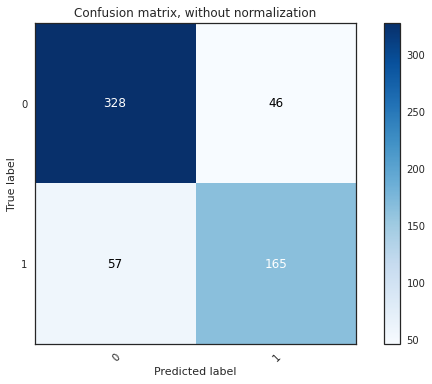

In [84]:
sns.set_style('white')
plot_confusion_matrix(y_true=y_train_1, y_pred=logreg_model1.predict(X_train_1), classes=np.sort(y_train_1.unique()));

Confusion matrix, without normalization
[[153  22]
 [ 25  95]]


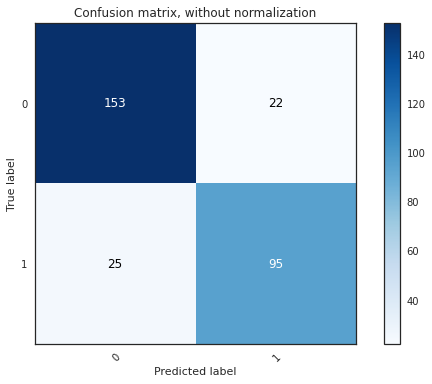

In [85]:
plot_confusion_matrix(y_true=y_valid_1, y_pred=logreg_model1.predict(X_valid_1), classes=np.sort(y_valid_1.unique()));